<Body>   
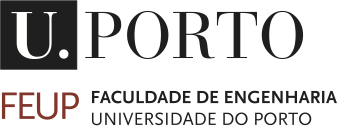   
<h1> <b>Computer Vision </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# Semantic Segmentation in Pytorch

## Introduction

What is segmentation in the first place?
It is partitioning an image into clusters of ‘similar’ pixel (e.g., line segments, curve segments, circles, etc). $\color{green}{Semantic\textit{ }segmentation}$ aims to recognize, understand what's in the image in pixel-level.

Example of figure 1: "Two persons riding on a bike and there are 3 cars in their left side" (see figure 1).


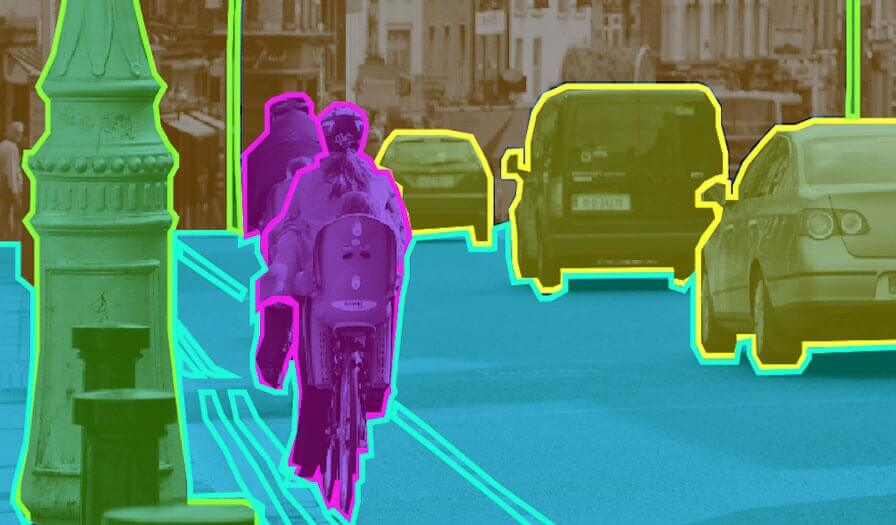

(Figure 1)

> Early ideas for the transition between classification to segmentation:
* do a classification on each superpixel.

This motivates exploring the use of CNNs for pixel-level labelling problems. The key insight is to learn a strong feature representation end-to-end for the pixel-level labelling task instead of hand-crafting features with heuristic parameter tuning. Thus, it is possible to use a Fully Convolutional Networks for Semantic Segmentation (see figure 2).

Adapting CNNs designed for high level computer vision tasks such as object recognition to pixel-level labelling tasks brings some $\color{green}{challenges}$ related to (see figure 3):

* CNNs have convolutional filters with large receptive fields and hence **produce coarse outputs when restructured to produce pixel-level labels**. The presence of maxpooling layers in CNNs further reduces the chance of getting a fine segmentation output. This can result in non-sharp boundaries and blob-like shapes in semantic segmentation tasks.
* CNNs lack smoothness constraints that encourage label agreement between similar pixels, and spatial and appearance consistency of the labelling output. Lack of such smoothness constraints can result **in poor object delineation and small spurious regions** in the segmentation output.


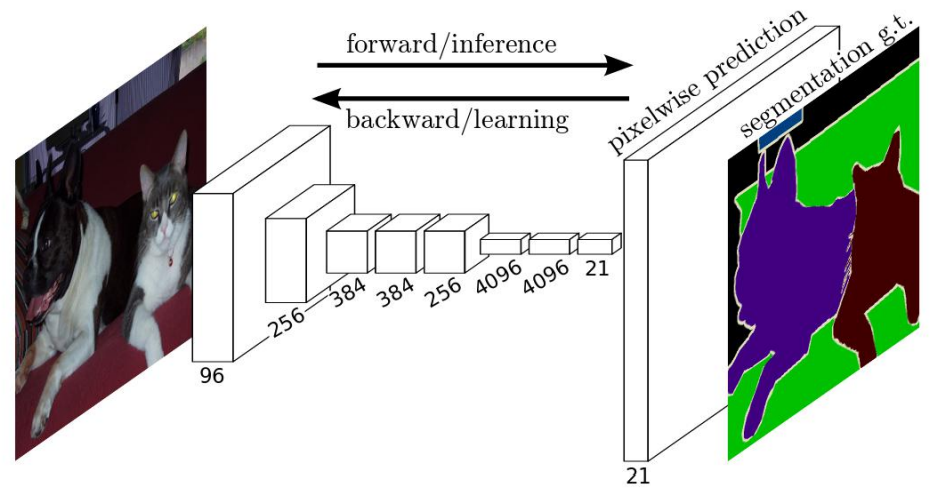

(Figure 2)

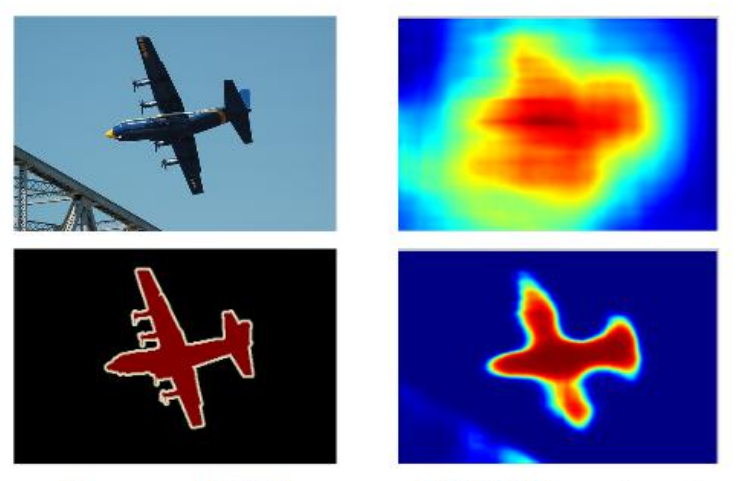

(Figure 3: Image and GT on the left,  and, CNN output on the right)


Complementing the CNN, probabilistic graphical models have been developed as effective methods to enhance the accuracy of pixel-level labelling tasks. In particular, Markov Random Fields
(MRFs) and its variant Conditional Random Fields (CRFs).
> The key idea of CRF inference for semantic labelling is to formulate the label assignment problem as a probabilistic inference problem that incorporates assumptions such as the label agreement between similar pixels. CRF inference is able to refine weak and coarse pixel-level label predictions to produce sharp boundaries and fine-grained segmentations.

These probabilistic approaches are a bit out of scope for this notebook. Read article [1] for additional information about the topic.

Finally, the design of networks that relies on convolutional layers with downsampling and upsampling layers has provided good results as well. The most well know model is called U-Net.

This notebook will:
1. Explore the U-Net architecture
2. Implement semantic segmentation using U-Net


# The U-Net architecture:

The figure 4 represents a typical U-Net model where the input image is of the shape 3 x 96 x 128. In this example, the number of classes present in the image is 21, this means that the output needs to have 21 channels.
> The U-Net model is formed by 3 parts: 1) Encoding; 2) Decoding; and, 3) Output segmentation map.

An innovative feature of U-Net model is the skip connections (shown with grey arrows - Torch cat), which enable the flow of information from the encoder side to the decoder side, enabling the model to make better predictions.

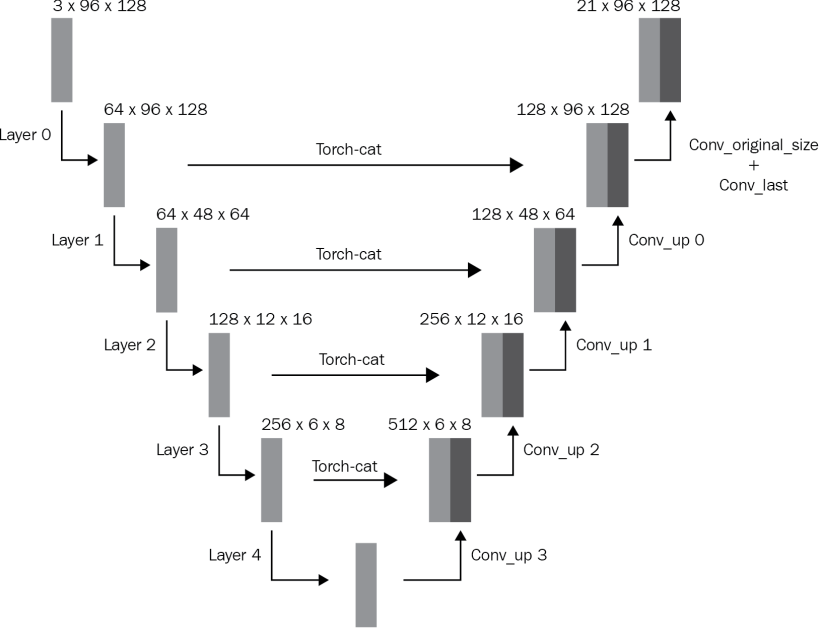

(Figure 4. U-Net architecture. Figure from the book. The schematic of the model is merely representative since it is not used or implemented below.)

1. $\color{red}{Encoding}$ Part is a simple convolution network that keeps reducing the size of image while the number of channels keeps increasing.

For example: two 3x3 Convolution layers followed by a Relu activation function are stacked together (Sequentially) and a 2x2 maxpool layer is applied after that.

2. $\color{red}{Decoding}$ part is upscaling the downscaled image, back to the original height and width but with as many channels as there are classes. While upscaling, feature information from the left side is combined with the right side image using **skip connections**, which aims to preserve the structure/objects in the original image.

For example: two 3x3 Convolution layers stacked together (Sequentially) like left side but there is no maxpool layer used, instead a 2x2 Transpose convolution layer is used.

3. $\color{red}{Output\text{ }segmentation\text{ }map}$ is obtained by an extra convolution layer.

For example: at the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes.



## What is upscaling ?

The upscaling is performed using the [`nn.ConvTranspose2d` method](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), which takes the number of input channels, the number of output channels, the kernel size, and stride as input parameters.

An example calculation for `ConvTranspose2d` is as follows:  input array of shape 3 x 3 (Input array), applied a stride of 2 where we distributed the input values to accommodate the stride, padded the array with zeros, and convolved the padded input with a filter (Filter/Kernel) to fetch the output array.
> the optimal filter values learn to reconstruct the original image as much as possible. The filter weights and bias are optimized during the model training process.

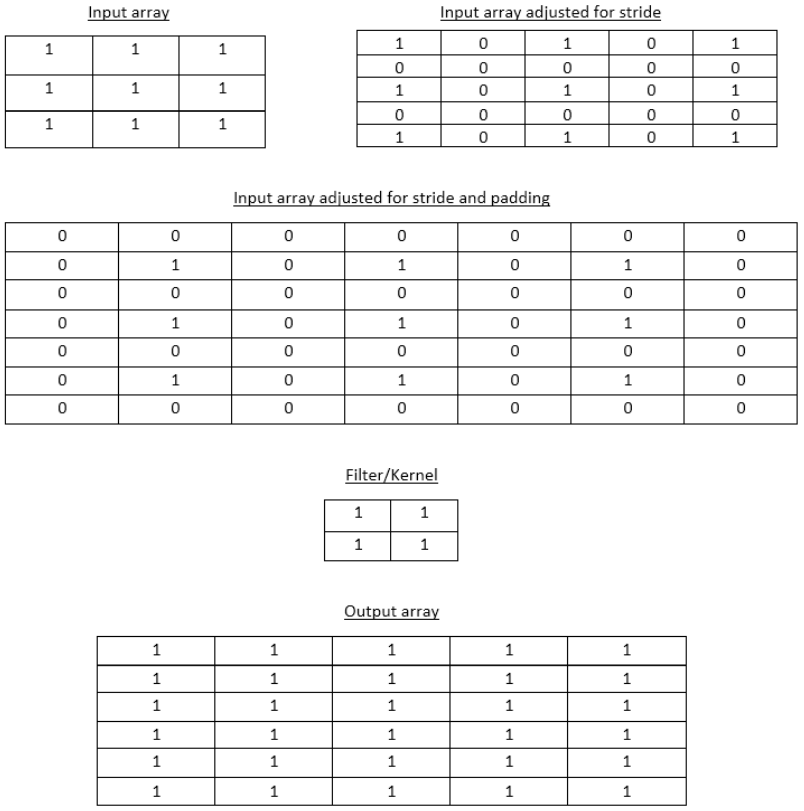

(Figure 5: nn.ConvTranspose2d method. Figure from the book)

In [ ]:
#Import the relevant packages:
import torch
import torch.nn as nn
import cv2

#  input channel's value is 1,the output channel's value is 1,
#  the kernel is (2,2), the stride= 2, and padding=0
#  note: Padding is calculated as dilation * (kernel_size - 1) - padding.
m = nn.ConvTranspose2d(1, 1, kernel_size=(2,2), stride=2, padding = 0)

# Input data
input = torch.ones(1, 1, 3, 3)
print(input)
#print(m.weight)

# Apply model
output = m(input)
output.shape
print(output)

# Access the weights of the filter
filters = m.weight
print("Filter shape:", filters.shape)  # Shape: (out_channels, in_channels, kernel_height, kernel_width)
print("Filter values:\n", filters)


tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])
tensor([[[[-0.1294,  0.0677, -0.1294,  0.0677, -0.1294,  0.0677],
          [ 0.4511,  0.1182,  0.4511,  0.1182,  0.4511,  0.1182],
          [-0.1294,  0.0677, -0.1294,  0.0677, -0.1294,  0.0677],
          [ 0.4511,  0.1182,  0.4511,  0.1182,  0.4511,  0.1182],
          [-0.1294,  0.0677, -0.1294,  0.0677, -0.1294,  0.0677],
          [ 0.4511,  0.1182,  0.4511,  0.1182,  0.4511,  0.1182]]]],
       grad_fn=<ConvolutionBackward0>)
Filter shape: torch.Size([1, 1, 2, 2])
Filter values:
 Parameter containing:
tensor([[[[-0.1692,  0.0279],
          [ 0.4113,  0.0785]]]], requires_grad=True)


## Implementing semantic segmentation

In [ ]:
!pip install -q torch_snippets pytorch_model_summary
!pip install torch
import torch
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split

# downloading datasets
import os
if not os.path.exists('dataset1'):
    !wget --output-document=dataset1.zip "https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/EcIJ186fy35Em-I83Alnz2ABnoJc9NMAI5p4SRhN7ZHSGQ?download=1"
    !unzip -q dataset1.zip
    !rm dataset1.zip


# enabling GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.5 MB/s eta 0:00:00
--2024-11-26 17:17:52--  https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt

In [ ]:
# Data augmentation / Normalization
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]
                                 ) # for imagenet
                             ])
tfms = get_transforms()

### Define the "Dataset Class"

Start by importing the Dataset class from the `torch.utils.data` module. Each PyTorch dataset is required to inherit from Dataset class  and should have a `__len__` and a `__getitem__` method.

Some implementation notes:
* `__init__` specifies the image location.
* `__len__` specifies the length of the dataset.
* `__getitem__` loads an image and mask and resizes both the input (image) and output (mask) images so that they're the same shape.
* The mask images from this dataset contain integers that range between [0,11]
* Define a function (`choose`) for selecting a random image index. This is mainly for debugging purposes.
* Define the `collate_fn` method for performing preprocessing on a batch of images.

In [ ]:
import torch.utils.data as data
class SegmentationDataset(data.Dataset):
    def __init__(self, split, transforms):
      	# Specify the folder that contains images i
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
        self.transforms = transforms

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.items)

    def __getitem__(self, ix):
        # load the image from disk
        image = cv2.imread(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224,224))


        # read the associated mask from disk in grayscale mode
        mask = cv2.imread(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png', 0)
        mask = cv2.resize(mask, (224,224))

        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        # grab the image path from the current index
        return image, mask

    def choose(self):
      return self[randint(len(self))]

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

### Define the training and validation datasets, and dataloaders

In [ ]:
# Create instances for training and validation sets.
trn_ds = SegmentationDataset(split = 'train', transforms=None)
val_ds = SegmentationDataset(split = 'test', transforms=None)

batch_size = 4

# Dataloaders
trn_dl = data.DataLoader(trn_ds, batch_size=batch_size, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = data.DataLoader(val_ds, batch_size=batch_size, shuffle=True, collate_fn=val_ds.collate_fn)

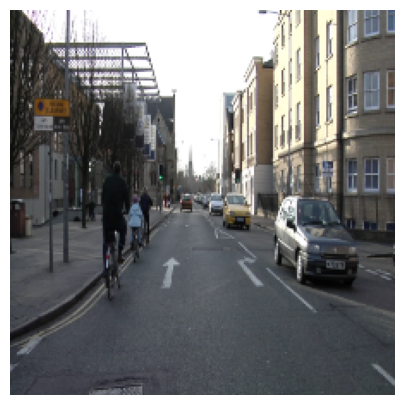

In [ ]:
show(trn_ds[10][0])

### Define the U-Net Model

The `torchvision.models` is a [subpackage](https://pytorch.org/vision/stable/models.html) that has definitions of many models suitable for image classification, pixel-wise semantic segmentation, object detection, instance segmentation, person keypoint detection, video classification, and optical flow.

VGG-16 is a convolutional neural network that is 16 layers deep. It is possible to load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

Loading the pretrained model [vgg16_bn](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16_bn.html) aims to accelerate the training procedure since it takes into consideration the weights already learnt. The implementation of VGG model can be confirmed [here](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py).  

The VGG16 with Batch Normalization model is used the encoder layer of the architecture. Several blocks need to be obtained for the encoder layer.




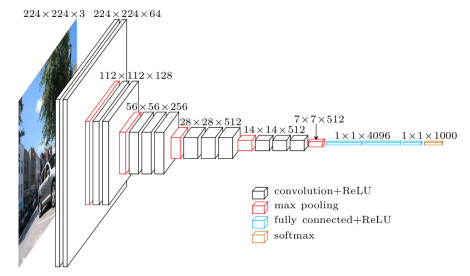

(Figure: VGG architecture)

In [ ]:
# Sequential operations of Conv2d -> BatchNorm -> ActivationFunction
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
#  ConvTranspose2d upscale the images.
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [ ]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        # Encoding
        self.encoder = vgg16_bn(pretrained=pretrained).features   #nn.Sequential behaves like python list of all layers (so can be sliced)
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        # Decoding
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)

        # Output layer
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1) # skip connection
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1) # skip connection
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1) # skip connection
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1) # skip connection
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1) # skip connection
        x = self.conv10(x)

        x = self.conv11(x)

        return x

### Define Loss function

In [ ]:
# Define the loss function
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

### Define Training procedure

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

### Train the model

In [ ]:
# Define the model, optimizer, loss function, and the number of epochs
model = UNet().to(device)

criterion = UnetLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20

# Uncomment:
# model.encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 146MB/s]


In [ ]:
# Train the model over increasing epochs
log_train_loss = []
log_train_acc = []
log_val_loss = []
log_val_acc = []

for ex in range(n_epochs):
    N = len(trn_dl)
    loss_avg = 0
    acc_avg = 0
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        print(ex+(bx+1)/N,"  Loss=", loss, "Accuracy=", acc)
        loss_avg+=loss;
        acc_avg += batch_size * acc;
    log_train_loss.append(loss_avg/N)
    log_train_acc.append(acc_avg/(N*batch_size))

    N = len(val_dl)
    loss_avg = 0
    acc_avg = 0
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        loss_avg+=loss;
        acc_avg += batch_size * acc;
        print(ex+(bx+1)/N,"  Loss=", loss, "Accuracy=", acc)
    log_val_loss.append(loss_avg/N)
    log_val_acc.append(acc_avg/(N*batch_size))


0.010869565217391304   Loss= 2.699167013168335 Accuracy= 0.051309388130903244
0.021739130434782608   Loss= 2.3687455654144287 Accuracy= 0.175641730427742
0.03260869565217391   Loss= 2.224754571914673 Accuracy= 0.2724260687828064
0.043478260869565216   Loss= 2.086472272872925 Accuracy= 0.45682695508003235
0.05434782608695652   Loss= 2.0270440578460693 Accuracy= 0.5178172588348389
0.06521739130434782   Loss= 1.92220139503479 Accuracy= 0.5975914597511292
0.07608695652173914   Loss= 1.9497443437576294 Accuracy= 0.5990613102912903
0.08695652173913043   Loss= 1.9030853509902954 Accuracy= 0.5783790946006775
0.09782608695652174   Loss= 1.7454204559326172 Accuracy= 0.6636738777160645
0.10869565217391304   Loss= 1.7838822603225708 Accuracy= 0.6529266834259033
0.11956521739130435   Loss= 1.6768865585327148 Accuracy= 0.7099111080169678
0.13043478260869565   Loss= 1.752773642539978 Accuracy= 0.6500169038772583
0.14130434782608695   Loss= 1.8183263540267944 Accuracy= 0.5523656606674194
0.15217391304

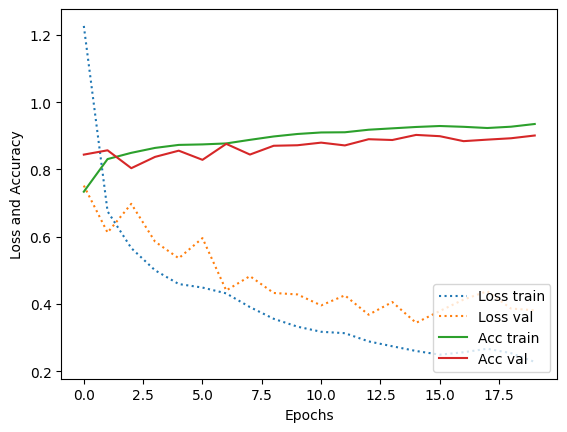

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(log_train_loss, linestyle = 'dotted',  label='Loss train')
plt.plot(log_val_loss, linestyle = 'dotted',  label='Loss val')
plt.plot(log_train_acc, label='Acc train')
plt.plot(log_val_acc, label='Acc val')
plt.legend(loc='lower left  ')
plt.show()

### See the segmentation result

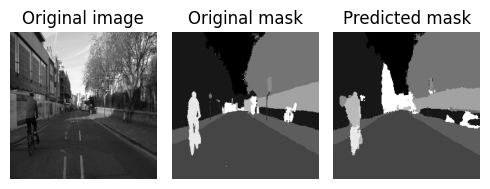

In [ ]:
# Obtain a sample
im, mask = next(iter(val_dl))

# Feedforward
_mask = model(im)

_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

----------------------
# Exercise

Design another UNet model by taking into consideration the previous demontrator (the same dataset). In this case, the model shall be developed without resorting to a pre-trained model (VGG, ResNet or other).

a) This UNet needs to have:
* input and output layers are convolutions
* 4 encoding levels (with a feature depth of 128, 246, 512 and 512, respectively)
* 4 decoding levels (with a feture depth of 256, 128, 64 and 64, respectively).
* output is given by a sigmoid function.

b) Use the same dataset for training the model with SGD and Adam optimizers.

c) Discuss the results obtained in comparisson with the UNet used in the demontrator.

Tip: focus your attention on the cells with the mark **"To BE COMPLETED"**



In [ ]:
# Copy and Paste from above
#Import the relevant packages:

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import cv2

!pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split

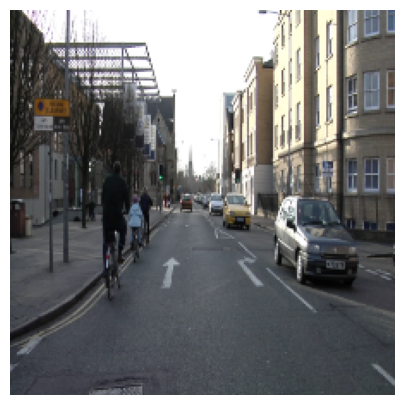

In [ ]:
# Copy and Paste from above
# downloading datasets
import os
if not os.path.exists('dataset1'):
    !wget --output-document=dataset1.zip "https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/Ea3iZsuffmJJiMgLZf9G3DIBrqpj0forsiY7YWRIx1UC4g?download=1"
    !unzip -q dataset1.zip
    !rm dataset1.zip


# enabling GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data augmentation / Normalization
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]
                                 ) # for imagenet
                             ])
tfms = get_transforms()

class SegmentationDataset(Dataset):
    def __init__(self, split, transforms):
      	# Specify the folder that contains images i
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
        self.transforms = transforms

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.items)

    def __getitem__(self, ix):
        # load the image from disk
        image = cv2.imread(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224,224))


        # read the associated mask from disk in grayscale mode
        mask = cv2.imread(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png', 0)
        mask = cv2.resize(mask, (224,224))

        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        # grab the image path from the current index
        return image, mask

    def choose(self):
      return self[randint(len(self))]

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks


# Create instances for training and validation sets.
trn_ds = SegmentationDataset(split = 'train', transforms=None)
val_ds = SegmentationDataset(split = 'test', transforms=None)

batch_size = 4

# Dataloaders
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, collate_fn=val_ds.collate_fn)

show(trn_ds[10][0])

# Define the loss function
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [ ]:
# Copy and Paste from above
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [ ]:
# solution a)

# **************************   To BE COMPLETED
# **************************   To BE COMPLETED
# Check this solution

import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    """
    Class that performs:
       conv => BN => ReLU => conv => BN => ReLU
    """
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    """
    Input Convolution
    """
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    """
    Class that downsizes:
       1. MaxPooling
       2. conv => BN => ReLU => conv => BN => ReLU
    """
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2),
                                    double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    """
    Class that upsizes:
       1. Upsample or ConvTranspose2d
       2. conv => BN => ReLU => conv => BN => ReLU
    """
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    """
    Output Convolution
    """
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        # Input Convolution
        self.inc = inconv(n_channels, 64)

        # Down Level to 128 features
        self.down1 = down(64, 128)
        # Down Level to 256 features
        self.down2 = down(128, 256)
        # Down Level to 512 features
        self.down3 = down(256, 512)
        # Down Level to 512 features
        self.down4 = down(512, 512)

        # Up Level to 256 features. Input 2x (due to skipconnection)
        self.up1 = up(512, 256)
        # Up Level to 128 features. Input 2x (due to skipconnection)
        self.up2 = up(256, 128)
        # Up Level to 64 features. Input 2x (due to skipconnection)
        self.up3 = up(128, 64)
        # Up Level to 64 features. Input 2x (due to skipconnection)
        self.up4 = up(64, 64)

        # Output Convolution
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        # Encoding path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoding path
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Output layer with sigmoid activation
        x = self.outc(x)
        return torch.sigmoid(x)

In [ ]:
# **************************   To BE COMPLETED
# **************************   To BE COMPLETED

In [ ]:
# Copy and Paste from above

# Train the model over increasing epochs
log_train_loss = []
log_train_acc = []
log_val_loss = []
log_val_acc = []

for ex in range(n_epochs):
    N = len(trn_dl)
    loss_avg = 0
    acc_avg = 0
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        print(ex+(bx+1)/N,"  Loss=", loss, "Accuracy=", acc)
        loss_avg+=loss;
        acc_avg += batch_size * acc;
    log_train_loss.append(loss_avg/N)
    log_train_acc.append(acc_avg/(N*batch_size))

    N = len(val_dl)
    loss_avg = 0
    acc_avg = 0
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        loss_avg+=loss;
        acc_avg += batch_size * acc;
        print(ex+(bx+1)/N,"  Loss=", loss, "Accuracy=", acc)
    log_val_loss.append(loss_avg/N)
    log_val_acc.append(acc_avg/(N*batch_size))

0.010869565217391304   Loss= 0.2603321373462677 Accuracy= 0.9260951280593872
0.021739130434782608   Loss= 0.21175707876682281 Accuracy= 0.940205454826355
0.03260869565217391   Loss= 0.20489107072353363 Accuracy= 0.9410774111747742
0.043478260869565216   Loss= 0.22459641098976135 Accuracy= 0.9365682601928711
0.05434782608695652   Loss= 0.22226309776306152 Accuracy= 0.9381228089332581
0.06521739130434782   Loss= 0.18329308927059174 Accuracy= 0.9504045844078064
0.07608695652173914   Loss= 0.13531844317913055 Accuracy= 0.9609673619270325
0.08695652173913043   Loss= 0.267381876707077 Accuracy= 0.9228664636611938
0.09782608695652174   Loss= 0.23894734680652618 Accuracy= 0.941316545009613
0.10869565217391304   Loss= 0.1724613755941391 Accuracy= 0.949148952960968
0.11956521739130435   Loss= 0.28984105587005615 Accuracy= 0.9165935516357422
0.13043478260869565   Loss= 0.23068785667419434 Accuracy= 0.9332051277160645
0.14130434782608695   Loss= 0.21597251296043396 Accuracy= 0.937674343585968
0.15

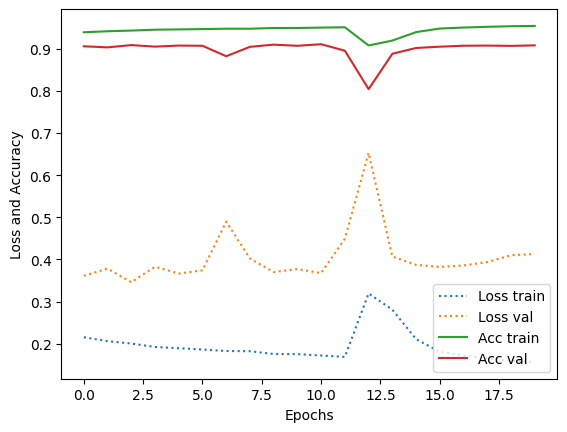

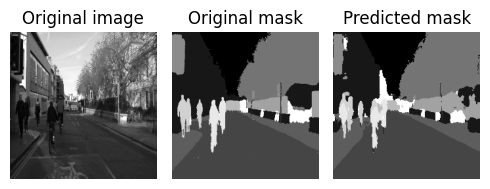

In [ ]:
# Copy and Paste from above

plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(log_train_loss, linestyle = 'dotted',  label='Loss train')
plt.plot(log_val_loss, linestyle = 'dotted',  label='Loss val')
plt.plot(log_train_acc, label='Acc train')
plt.plot(log_val_acc, label='Acc val')
plt.legend(loc='lower right')
plt.show()

# Obtain a sample
im, mask = next(iter(val_dl))

# Feedforward
_mask = model(im)

_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

In [ ]:
# solution b)

# replace the Adam by te SGD
# **************************   To BE COMPLETED
# **************************   To BE COMPLETED

Solution c) ......

--------------------------------
# References

[1] Conditional Random Fields as Recurrent Neural Networks

[2] Kishore and Reddy, A modern computer vision with Pytorch, Packt, 2020.